#### Credit Default Prediction Model: Enhancing Lending Risk Assessment Through Advanced Analytics

##### Problem Statement
Traditional credit assessment methods lack precision in predicting loan defaults, leading to missed revenue opportunities and significant portfolio losses from qualified borrowers incorretly deemed as high-risk or vice-versa. We need to develop an advanced predictive model that can leverage our comprehensive dataset of financial indicators, demographic information, and loan characteristics, to more accurately classify potential defaulters. This model will minimize default-related losses to the lending institution and optimize lending decisions that balance portfolio growth with appropriate risk management.

In [1]:
# Import libraries
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
warnings.simplefilter(action="ignore", category=FutureWarning)

##### Prepare the Data

In [2]:
# Load the dataset
df = pd.read_csv("Project 1 Finance Predictive Analysis-ML.csv")
df.head()

,customer_id,loan_id,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,application_date,approval_date,disbursement_date,due_date,default_status
0,CUST-00004912,LN00004170,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,05-04-2018,23-04-2018,24-04-2018,14-08-2018,False
1,CUST-00004194,LN00002413,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,30-12-2022,31-12-2022,12-01-2023,05-04-2023,False
2,CUST-00003610,LN00000024,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,15-11-2019,18-11-2019,27-11-2019,24-02-2020,False
3,CUST-00001895,LN00001742,Car Loan,55886,0.062155,30,Full-time,Low,795,Female,Married,PhD,25-08-2021,08-09-2021,11-09-2021,25-02-2022,False
4,CUST-00003782,LN00003161,Home Loan,7265,0.070635,48,Part-time,Low,519,Female,Married,High School,02-09-2020,07-09-2020,11-09-2020,29-12-2020,False


In [3]:
#Check the column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        5000 non-null   object 
 1   loan_id            5000 non-null   object 
 2   loan_type          5000 non-null   object 
 3   loan_amount        5000 non-null   int64  
 4   interest_rate      5000 non-null   float64
 5   loan_term          5000 non-null   int64  
 6   employment_type    5000 non-null   object 
 7   income_level       5000 non-null   object 
 8   credit_score       5000 non-null   int64  
 9   gender             5000 non-null   object 
 10  marital_status     5000 non-null   object 
 11  education_level    5000 non-null   object 
 12  application_date   5000 non-null   object 
 13  approval_date      5000 non-null   object 
 14  disbursement_date  5000 non-null   object 
 15  due_date           5000 non-null   object 
 16  default_status     5000 

In [4]:
#Drop high cardinality features
df.drop(columns=["customer_id","loan_id"], inplace=True)

In [5]:
def group_credit_score(name):
    if 'credit_score_' in name:
        score = int(name.split('_')[-1])
        if 800 <= score <= 850:
            return "Credit Score: Excellent"
        elif 740 <= score < 800:
            return "Credit Score: Very Good"
        elif 670 <= score < 740:
            return "Credit Score: Good"
        elif 580 <= score < 670:
            return "Credit Score: Fair"
        elif 300 <= score < 580:
            return "Credit Score: Poor"
    return name


In [6]:
#Change default_status from boolean to integer
df["default_status"] = df['default_status'].astype(int)

##### Explore the data
Since the model is a type of linear model, it is paramount to make sure the dataset does not have issues with multicollinearity
- Plot a correlation heatmap of the remaining numerical features in the df. Since "default status" is the target, we won't include it

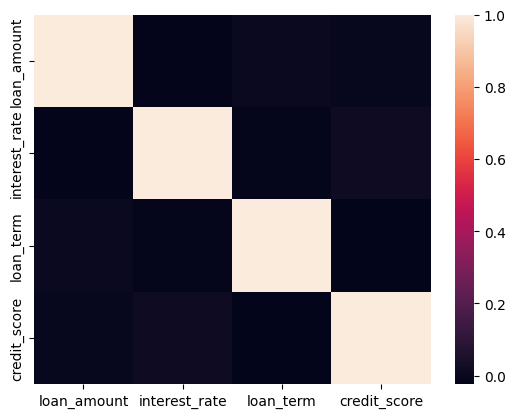

In [7]:
#Create a correlation matrix
correlation = df.select_dtypes("number").drop(columns="default_status").corr()
correlation
#plot the heatmap of correlation
sns.heatmap(correlation);

Use seaborn to create a boxplot that shows the distribution of  "credit_score", "loan_amount", "loan_term", and "interest_rate" columns for both groups in "default_status"

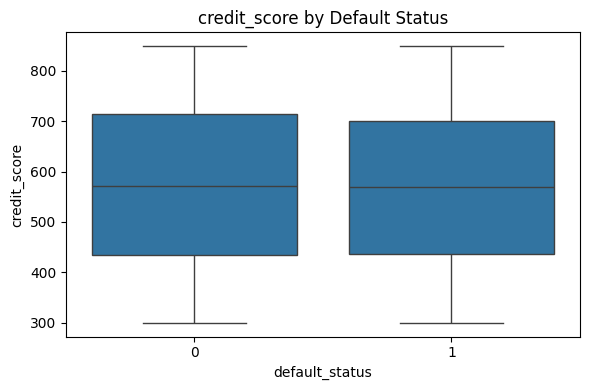

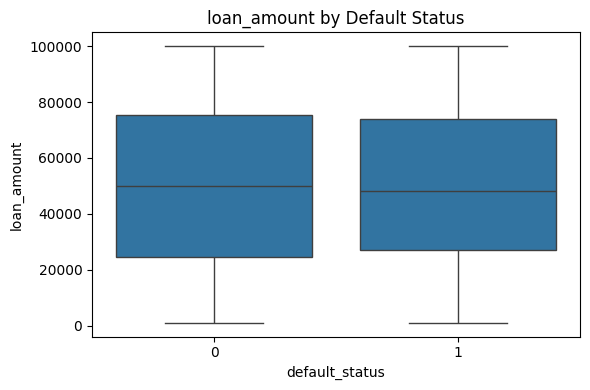

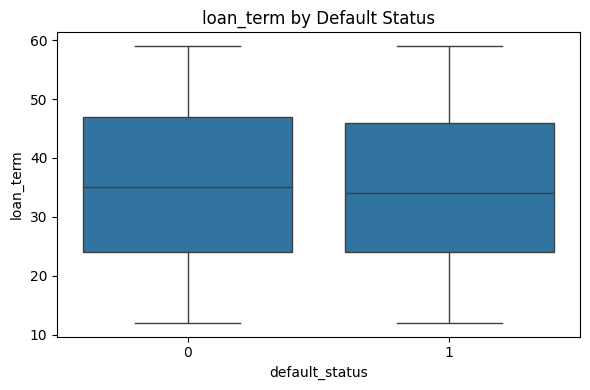

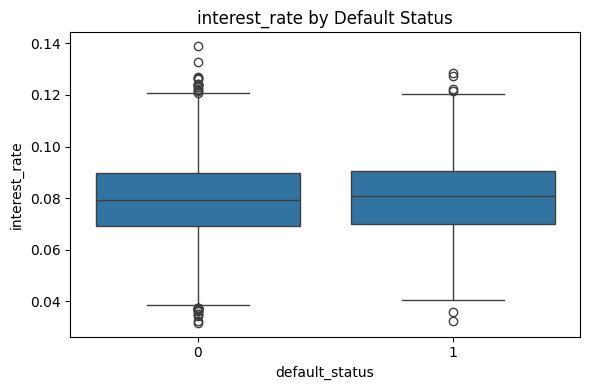

In [8]:
#Create the boxplot
columns = ["credit_score", "loan_amount",  "loan_term", "interest_rate"]
for column in columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="default_status", y=column, data=df)
    plt.title(f'{column} by Default Status')
    plt.tight_layout()
    plt.show()
    


Create a bar chart of the value counts for the "default status" column

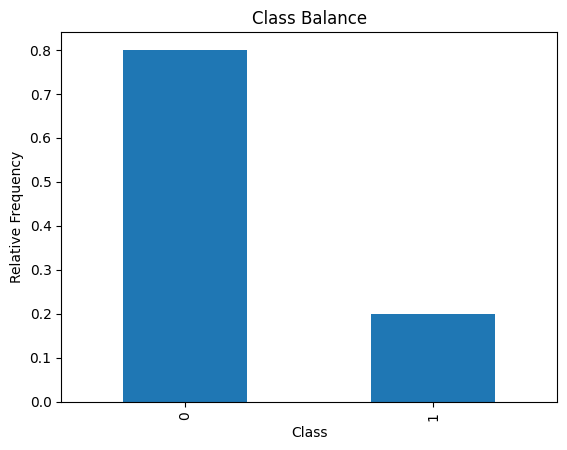

In [9]:
#Plot value_counts for "default_status"
df["default_status"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

Create two variables to store the normalized value counts for the two classes in df["default_status"]

In [10]:
majority_class, minority_class = df["default_status"].value_counts(normalize=True)
print(majority_class, minority_class)

0.8002 0.1998


Are there clients with certain loan_type that are more likely to default? Create a pivot table where the "loan_type" is the index, values come from "default_status" aggregated by mean

In [11]:
#Create pivot table
loan_type_pivot = pd.pivot_table(
    df, index="loan_type", values="default_status", aggfunc=np.mean
).sort_values(by="default_status")
loan_type_pivot

,default_status
loan_type,
Education Loan,0.176819
Home Loan,0.196994
Personal Loan,0.199844
Car Loan,0.223881


How do proportions in loan_type_pivot compare to the majority and minority classes

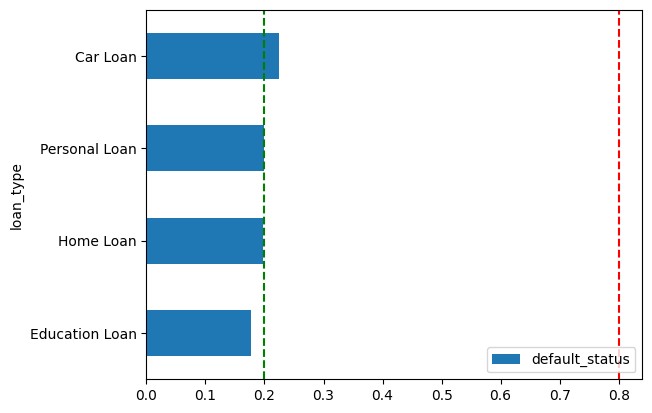

In [12]:
#Create a bar chart of loan_type_pivot
loan_type_pivot.plot(kind="barh")
plt.axvline(majority_class, linestyle="--", color="red")
plt.axvline(minority_class, linestyle="--", color="green")
plt.legend(loc="lower right");

##### Split the data into train and test sets
Create the feature X and target vector y. The target is "default_status"

In [13]:
target = "default_status"
X= df.drop(columns=target)
y = df[target]

In this step, we divide the data (X and y) into training and test sets in a randomized test split. The test set should be 20% and a random state of 42 for reproducibility

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4000, 14)
y_train shape: (4000,)
X_test shape: (1000, 14)
y_test shape: (1000,)


##### Build model
Baseline
Calculate the baseline accuracy score for your model.

What's accuracy score?

In [15]:
acc_baseline =y_train.value_counts(normalize=True).max()
print("Baseline accuracy:", round(acc_baseline, 2))

Baseline accuracy: 0.8


Create a pipeline named lr that contains OneHotEncoder transformer and LogisticRegression as the predictor, be sure to set the use_cat_names to True

In [16]:
lr =make_pipeline(
    OneHotEncoder(handle_unknown='ignore',
        sparse_output=False),
    LogisticRegression(C=0.1,max_iter=1000)
)
lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

##### Evaluating the model
Calculate the training and test accuracy scores for your models

In [17]:
acc_train = accuracy_score(y_train, lr.predict(X_train))
acc_test = lr.score(X_test, y_test)
print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test,2))

Training Accuracy: 0.8
Test Accuracy: 0.8


##### Communicating Insights
Extract features names and importances from the model

In [18]:
features = lr.named_steps["onehotencoder"].get_feature_names_out()
importances = lr.named_steps["logisticregression"].coef_.flatten()

Create a pandas Series named odds_ratios, where the index is features and the values are your the exponential of the importances

In [19]:
# Create an odds_ratio Series
odds_ratio = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratio.head()

loan_term_22        0.757783
loan_term_50        0.758167
loan_term_15        0.768584
loan_term_56        0.787157
credit_score_764    0.835197
dtype: float64

Create a horizontal bar chart with the five largest coefficients from odds_ratios. Be sure to label your x-axis "Odds Ratio".

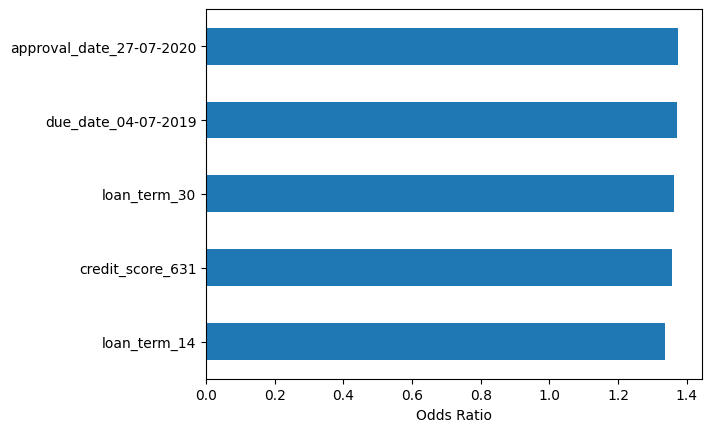

In [20]:
# Horizontal bar chart of the large coefficients
odds_ratio.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

Create a horizontal bar chart with the five smallest coefficients from odds_ratios. Be sure to label your x-axis "Odds Ratio"

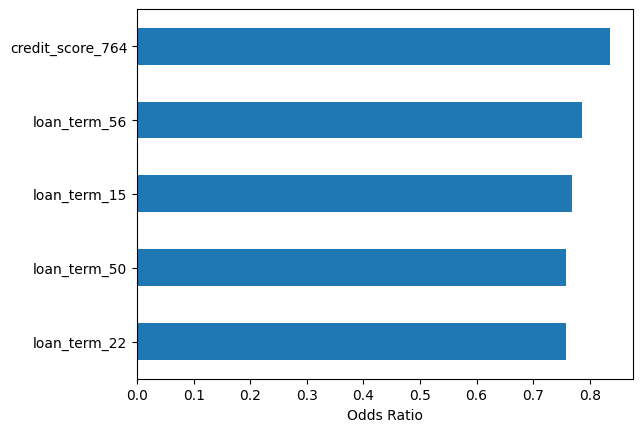

In [21]:
# Horizontal bar chart of the small coefficients
odds_ratio.head().plot(kind="barh")
plt.xlabel("Odds Ratio");